In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import math
import cv2
from sklearn import model_selection


In [2]:
model_name = 'model'
data_path = './data__/'
batch_size = 8
samples_epoch = batch_size * 6
n_epochs = 1
df = pd.read_csv(data_path + 'driving_log.csv')
train, valid = model_selection.train_test_split(df, test_size=0.1)

In [3]:
def generate_samples(df, batch_size, data_path):
    
    size = df.iloc[:,3].size
    offset = 0.23
    
    n_bin = 100
    
    vmin = np.absolute(df.values[:,3]).min()
    vmax = np.absolute(df.values[:,3]).max()
    
    bins = np.linspace(vmin, vmax, num=n_bin+1)
    bin_inds = np.digitize(df[[3]].values, bins, right= True)

    while True:
        imgs = np.zeros([0, 80, 160, 1], dtype='uint8')
        steerings = np.zeros(0, dtype='float32')

        for i in range(batch_size):
            # choose a bin
            upper_bound = np.random.choice(np.arange(1,n_bin + 1))
            indices = df[bin_inds == upper_bound].index

            while indices.size == 0:
                upper_bound = np.random.choice(np.arange(1,n_bin + 1))
                indices = df[bin_inds == upper_bound].index
            
            index_begin = np.random.choice(indices)            

            camera = np.random.choice([0,1,2])

            flip = np.random.randint(2)
            
            
            file_path = df.iloc[index_begin, camera]
            _, _, filename = file_path.partition('IMG')

            img = cv2.imread(data_path + 'IMG' + filename)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = img[60:140 ,:]
            img = cv2.resize(img, (160, 80))
            img = img[...,None]

            steering = df.iloc[index_begin, 3]

            if camera == 1:
                steering += offset
            elif camera == 2:
                steering -= offset

            if flip:
                img = np.fliplr(img)
                steering = -steering

            imgs = np.append(imgs, [img], axis=0)
            steerings = np.append(steerings, [steering], axis=0)

        yield imgs, steerings


In [4]:
for imgs, steerings in generate_samples(df, 20, data_path):
    global my_images, my_steerings
    my_images, my_steerings = imgs, steerings
    break


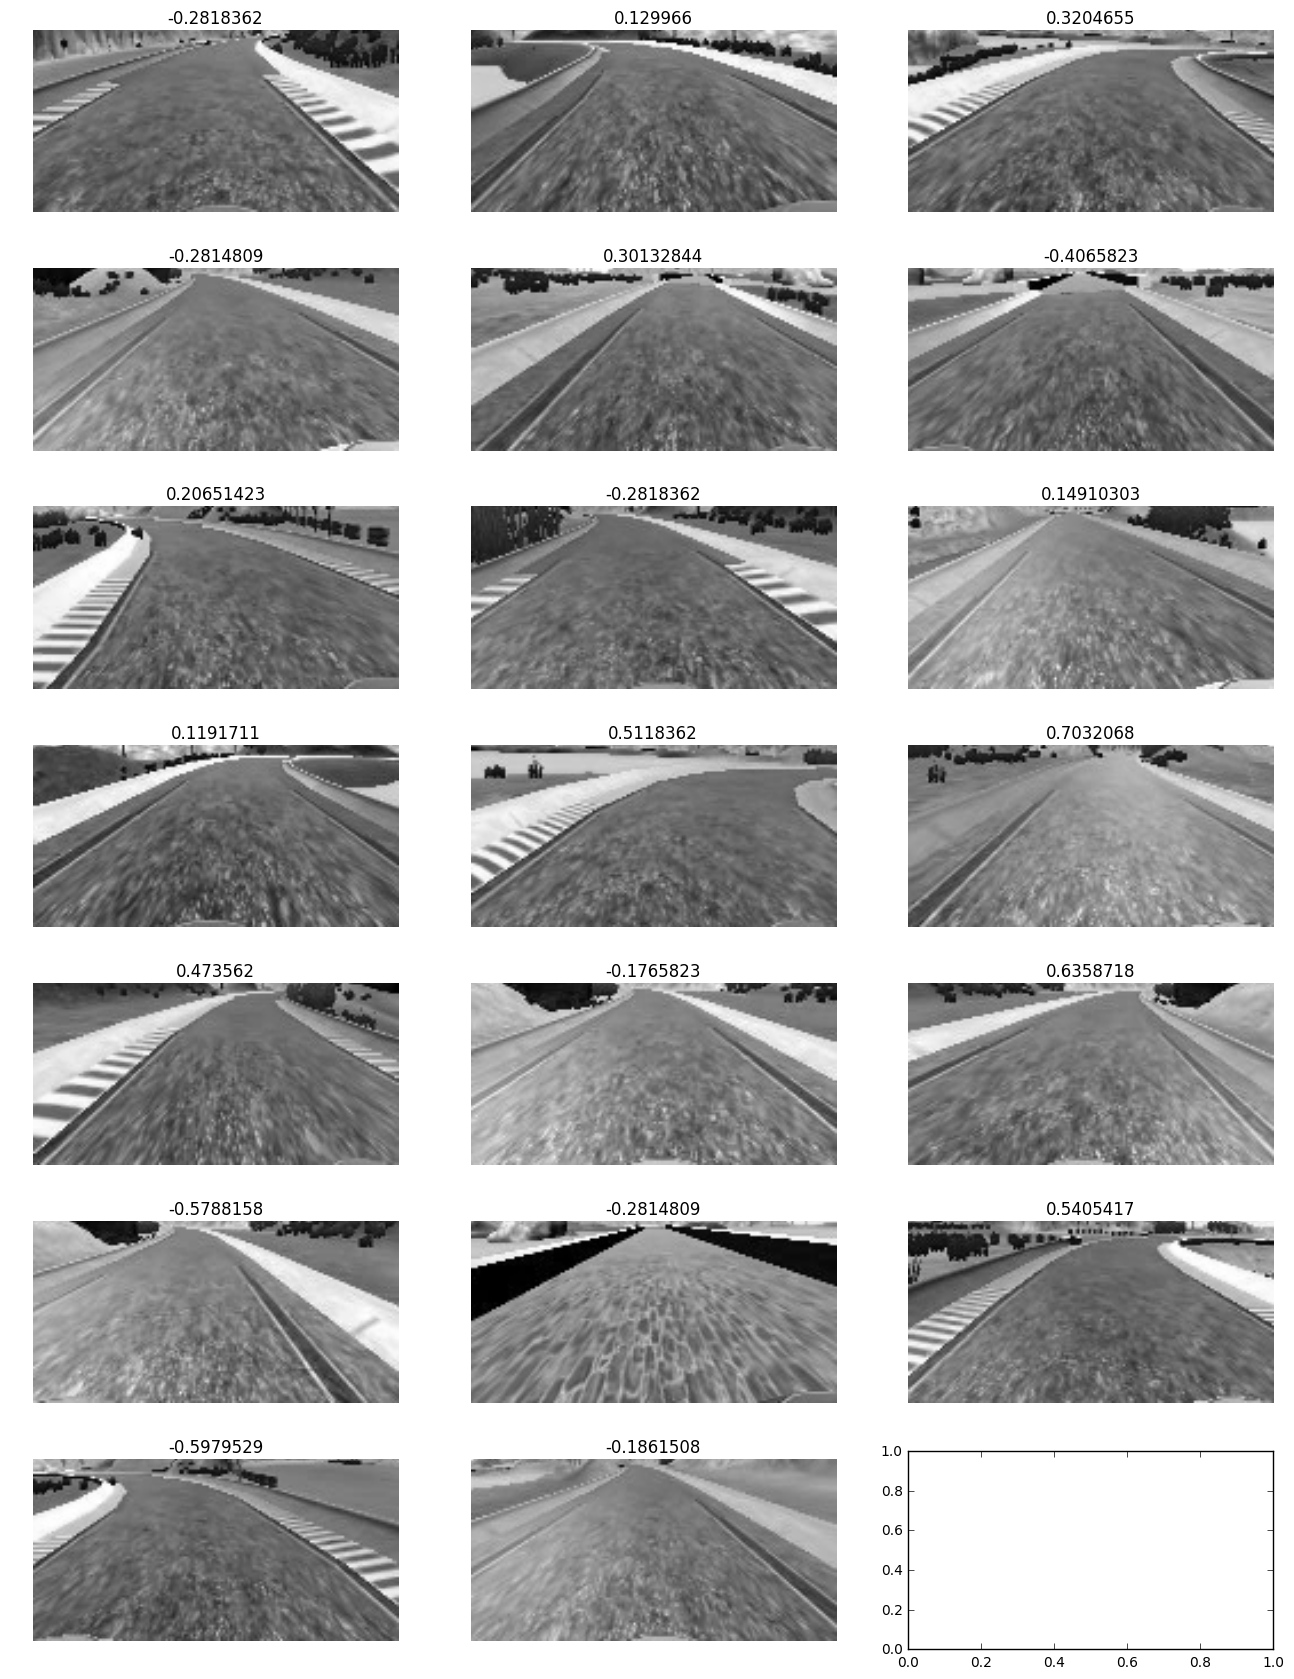

In [6]:
plot_imgs(my_images, my_steerings)

In [ ]:
fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(1,1,1)
ax.scatter(np.arange(df.iloc[:,3].shape[0]), df.iloc[:,3].values, marker='.')
steering_per = len(df[df.iloc[:,3] != 0]) / len(df)
print ('frame with steering percentage {:.3f}'.format(steering_per))


In [5]:
def plot_imgs(imgs, steerings):
    if imgs.ndim == 4 and imgs.shape[3] == 1:
        imgs = imgs.squeeze(axis=3)
        
    plt.subplots_adjust()
    count = imgs.shape[0]
    n_col = 3
    n_row = math.ceil(count / n_col)
    n_row = 2 if n_row == 1 else n_row
    fig, ax = plt.subplots(n_row, n_col, figsize=[16, 6 * n_row/2] )
    for i in range(n_row):
        for j in range(n_col):
            ij = j + i * n_col
            if ij < count:
                ax[i,j].axis('off')
                ax[i,j].set_title(steerings[ij])
                ax[i,j].imshow(imgs[ij], cmap='gray')

In [ ]:
model.pred_steering().summary()